In [3]:
import torch 
from PIL import Image, ImageDraw
import json 
# import py360convert
import numpy as np 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy.ndimage.filters import gaussian_filter
import torch
import torch.nn as nn
import clip 

/tmp/ipykernel_461070/35247632.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [4]:
class SDRDataset(Dataset):
    def __init__(
        self,
        mode,
        args,
        texts,
        centers,
        panoids,
        route_ids,
    ):
        self.mode = mode
        self.args = args
        self.centers = centers
        self.texts = texts
        self.panoids = panoids
        self.route_ids = route_ids
        # if self.mode == 'train':
            # self.mode = 'train_augmented'
        # self.bbox_data = torch.load(f'{args.processed_save_path}/{args.rpn_mode}/best_bbox_arr_{self.mode}_{args.text_feature_mode}_all_floors.pt')
        self.image_size = [
            3,
            200,
            500,
        ]

        self.preprocess_data_aug = transforms.Compose(
            [
                transforms.ColorJitter(brightness=0.5, hue=0.1, saturation=0.1),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.48145466, 0.4578275, 0.40821073], # [0.485, 0.456, 0.406, 0.555],
                    std= [0.26862954, 0.26130258, 0.27577711]# [0.229, 0.224, 0.225, 0.222],
                ),
            ]
        )
        self.preprocess = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.48145466, 0.4578275, 0.40821073], # [0.485, 0.456, 0.406, 0.555],
                    std= [0.26862954, 0.26130258, 0.27577711]# [0.229, 0.224, 0.225, 0.222],
                ),
            ]
        )

    def deconstruct_panoramas(self, index):
        all_maps = torch.zeros(
            self.args.max_floors,
            self.image_size[0],
            self.image_size[1],
            self.image_size[2],
        )
        panoid = self.panoids[index]
        # bboxes_on_floors = self.bbox_data[index]['floors']
        

        img = Image.open(
            f'{self.args.image_dir}/{panoid}.jpg'
        )
        for enum in range(self.args.max_floors):
            crop = img.crop((600*enum, 0, 600*(enum+1), 1500))
            crop = crop.resize((self.image_size[2], self.image_size[1]))
        # if int(f) in bboxes_on_floors:
        #     for bb in bboxes_on_floors[int(f)]:
        #         bbox_idx, _, bbox_coords = bb
        #         img = self.paint_bbox(img, bbox_coords, self.args.colors[bbox_idx % 6]) 
            print(all_maps.size(), self.preprocess_data_aug(crop).size())
            if "train" in self.mode:
                all_maps[enum, :, :, :] = self.preprocess_data_aug(crop)[:3, :, :]
            else:
                all_maps[enum, :, :, :] = self.preprocess(crop)[:3, :, :]


        return all_maps


    def paint_bbox(self, image, bbox, color):
        x1, y1, x2, y2 = bbox
        overlay = Image.new('RGBA', image.size, color+(0,))
        draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
        draw.rectangle((x1, y1, x2, y2), fill=color+(50,))

        # Alpha composite these two images together to obtain the desired result.
        image = Image.alpha_composite(image, overlay)
        return image

    def create_target(self, index, level, location):

        gaussian_target = np.zeros(
            (self.args.max_floors, self.image_size[1], self.image_size[2])
        )
        gaussian_target[int(level), location[0], location[1]] = 1
        gaussian_target[int(level), :, :] = gaussian_filter(
            gaussian_target[int(level), :, :],
            sigma=80.,
        )
        gaussian_target[int(level), :, :] = (
            gaussian_target[int(level), :, :]
            / gaussian_target[int(level), :, :].sum()
        )
        gaussian_target = torch.tensor(gaussian_target)
        gaussian_target = (
            nn.functional.interpolate(
                gaussian_target.unsqueeze(1),
                (self.args.ds_height, self.args.ds_width),
                mode="bilinear",
            )
            .squeeze(1)
            .float()
        )
        gaussian_target = gaussian_target / gaussian_target.sum()
        return gaussian_target

    def get_info(self, index):
        info_elem = [
            self.texts[index],
            self.panoids[index],
            self.route_ids[index],
        ]
        return info_elem

    def __getitem__(self, index):
        print(self.centers[index])
        location = [self.centers[index]['y'], self.centers[index]['x']]
        level = self.centers[index]["x"]*3000  // (3000 // 5)
        location = np.round(np.asarray(location) * self.args.ds_percent).astype(int)
        text = clip.tokenize(self.texts[index], truncate=True)  
        text = text.squeeze(0) 
        maps = self.deconstruct_panoramas(index)
        target = self.create_target(index, level, location)
        info_elem = self.get_info(index)
        return (
            info_elem,
            text,
            target,
            maps,
        )

    def __len__(self):
        return len(self.annotation_ids)

In [5]:
class SDRLoader:
    def __init__(self, args):
        self.datasets = {}
        self.args = args
    def load_json_data(self, data_path):
        route_ids, panoids, centers, texts = [], [], [], []
        prefix = 'main'
        with open(data_path) as f:
            for line in f:
                obj = json.loads(line)
                pano_type = prefix + '_pano'
                center_type = prefix + '_static_center'
                center = json.loads(obj[center_type])
                heading = prefix + '_heading'
                if center == {'x': -1,'y': -1}:
                    continue
                route_ids.append(obj['route_id'])
                panoids.append(obj['main_pano'])
                centers.append(center)
                texts.append(obj['td_location_text'])
        return route_ids, panoids, centers, texts
    
    def build_dataset(self, file):
        mode = file.split('/')[-1].split('.')[0]
        print(mode)
        route_ids, panoids, centers, texts = self.load_json_data(file)
        print("[{}]: Building dataset...".format(mode))
        
        dataset = SDRDataset(
            mode,
            self.args,
            texts,
            centers, 
            panoids,
            route_ids
        )
        self.datasets[mode] = dataset
        print("[{}]: Finish building dataset...".format(mode))
    

In [10]:
class args:
    image_dir = '/data1/saaket/jpegs_manhattan_touchdown_2021/'
    max_floors = 5
    ds_percent = 0.5
    ds_height = 57
    ds_width = 58

In [11]:
loader = SDRLoader(args)

In [12]:
loader.build_dataset('/data1/saaket/touchdown/data/train.json')

train
[train]: Building dataset...
[train]: Finish building dataset...


In [15]:
loader.datasets['train'][0][0]

{'x': 0.37777777777777777, 'y': 0.5483333333333333}
torch.Size([5, 3, 200, 500]) torch.Size([3, 200, 500])
torch.Size([5, 3, 200, 500]) torch.Size([3, 200, 500])
torch.Size([5, 3, 200, 500]) torch.Size([3, 200, 500])
torch.Size([5, 3, 200, 500]) torch.Size([3, 200, 500])
torch.Size([5, 3, 200, 500]) torch.Size([3, 200, 500])


["There's a black hydrant with a silver cap between two silver bollards on the sidewalk. Touchdown is on the cap of the hydrant.",
 's5hIdomk5NlH-bCnQFDLXQ',
 4787]

NameError: name 'image' is not defined

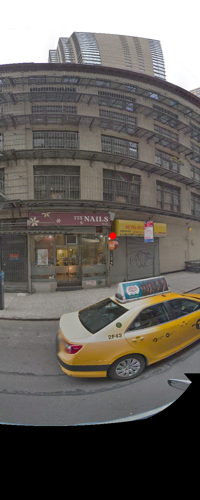

In [44]:
image.crop((600, 0, 1200, 1500)).resize((200, 500))

In [8]:
np_img = np.array(image)

In [10]:
np_img1 = np_img[:, :3000//8, :]

In [33]:
np_img1.shape

(1500, 375, 3)

In [28]:
ip = py360convert.e2p(np_img1, fov_deg=(-180, 180), u_deg=0, v_deg=0, out_hw=(800, 460), mode='nearest')

In [29]:
ip

array([[[139, 134, 131],
        [122, 118, 115],
        [117, 114, 109],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[139, 134, 131],
        [117, 111, 111],
        [122, 118, 115],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[127, 122, 116],
        [139, 134, 131],
        [117, 111, 111],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

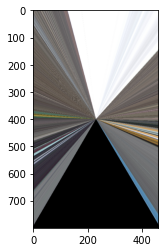

In [30]:
plt.imshow(ip)

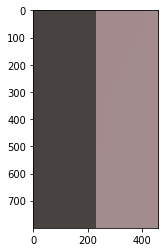

In [13]:
%matplotlib inline 

from matplotlib import pyplot as plt
plt.imshow(ip, interpolation='nearest')
plt.show()